In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from data_process import rolling_split
import matplotlib.pyplot as plt
import seaborn

return_test_day = [1,3,5]
prediction_parameters_dic = {"Forecast period":1, "time_rolling_window":22}


df_Macro = pd.read_csv("./Data/EURUSD_Macro.csv")
df_Macro["Last_Return"] =((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"]))
                          )

df_Macro["Predict_Return"] = ((df_Macro["PX_LAST"].pct_change(periods=prediction_parameters_dic["Forecast period"])
                      .dropna(ignore_index = True)))

df_Macro.dropna(inplace=True)
df_Macro

,Dates,PX_OPEN,PX_HIGH,PX_LOW,PX_LAST,DXY Curncy,GOLDS Comdty,USGG2YR Index,USGG5YR Index,USGG10YR Index,...,CAC Index,DAX Index,EURUSD 1M 25DC,EURUSD 1M 25DP,EURUSDV1M ATM,EURUSDV1W ATM,EUR1M Curncy,EUR12M Curncy,Last_Return,Predict_Return
1,1/3/2003,1.0358,1.0437,1.0342,1.0428,102.470,351.25,1.7499,2.9682,4.0169,...,3187.88,3092.94,10.07,10.07,10.0000,10.1500,-13.80,-122.00,0.006369,0.002685
2,1/6/2003,1.0420,1.0491,1.0416,1.0456,101.970,351.25,1.7983,3.0239,4.0518,...,3210.27,3157.25,10.40,10.39,10.3250,9.7000,-14.25,-120.50,0.002685,-0.004495
3,1/7/2003,1.0450,1.0456,1.0401,1.0409,102.570,347.25,1.7418,2.9751,4.0053,...,3160.99,3112.77,9.87,9.87,9.8000,9.3000,-13.75,-120.80,-0.004495,0.008646
4,1/8/2003,1.0405,1.0534,1.0363,1.0499,101.870,353.63,1.7257,2.9995,4.0169,...,3094.09,2993.00,9.92,9.92,9.8500,9.6250,-14.20,-120.65,0.008646,-0.001333
5,1/9/2003,1.0500,1.0538,1.0463,1.0485,101.940,352.75,1.8552,3.1747,4.1790,...,3152.29,3037.68,9.79,9.79,9.7250,9.9500,-13.84,-119.30,-0.001333,0.008679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5598,6/18/2024,1.0734,1.0761,1.0710,1.0740,105.256,2329.46,4.7120,4.2431,4.2227,...,7628.80,18131.97,6.68,8.20,7.2575,5.4950,16.09,188.07,0.000559,0.000372
5599,6/19/2024,1.0740,1.0753,1.0725,1.0744,105.254,2328.16,4.7120,4.2431,4.2227,...,7570.20,18067.91,6.50,7.97,7.0575,5.1975,15.62,188.63,0.000372,-0.003909
5600,6/20/2024,1.0745,1.0749,1.0702,1.0702,105.588,2360.09,4.7372,4.2746,4.2594,...,7671.34,18254.18,6.32,7.75,6.8575,5.2975,15.10,188.94,-0.003909,-0.000841
5601,6/21/2024,1.0702,1.0721,1.0671,1.0693,105.796,2321.98,4.7322,4.2742,4.2554,...,7628.57,18163.52,6.27,7.66,6.8200,5.2600,15.23,190.69,-0.000841,0.003741


In [2]:
df_Macro.columns

Index(['Dates', 'PX_OPEN', 'PX_HIGH', 'PX_LOW', 'PX_LAST', 'DXY Curncy',
       'GOLDS Comdty', 'USGG2YR Index', 'USGG5YR Index', 'USGG10YR Index',
       'USGG30YR Index', 'GTEUR10Y Govt', 'GTEUR30Y Govt', 'FEDL01 Index',
       'SPX Index', 'SX5E Index', 'UKX Index', 'CAC Index', 'DAX Index',
       'EURUSD 1M 25DC', 'EURUSD 1M 25DP', 'EURUSDV1M ATM', 'EURUSDV1W ATM',
       'EUR1M Curncy', 'EUR12M Curncy', 'Last_Return', 'Predict_Return'],
      dtype='object')

In [3]:
split_point = int(df_Macro.shape[0]*0.9)
df_train = df_Macro.iloc[:split_point,:]
df_test = df_Macro.iloc[split_point:,:]

x_train = df_train.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_train = df_train.loc[:, "Predict_Return"].to_numpy()

x_test = df_test.drop(columns=["Dates","Predict_Return"]).to_numpy()
y_test = df_test.loc[:, "Predict_Return"].to_numpy()

scale_x = StandardScaler()

x_train_norm = scale_x.fit_transform(x_train)
x_test_norm = scale_x.transform(x_test)

time_delta = prediction_parameters_dic["time_rolling_window"]
x_train_norm_rolling,x_test_norm_rolling = rolling_split(x_train_norm,time_delta),rolling_split(x_test_norm,time_delta)
y_train_rolling,y_test_rolling = y_train[time_delta-1:,...],y_test[time_delta-1:,...]

from data_process import splitting_entropy,threshold_search

threshold = threshold_search(y_train,1e-6)

print(threshold)

threshold = 0.002

0.001949


In [4]:
from data_process import labelize

y_train_rolling_label , y_test_rolling_label  = labelize(y_train_rolling,threshold),labelize(y_test_rolling,threshold) 

train_set = torch.utils.data.TensorDataset(torch.from_numpy(x_train_norm_rolling),torch.from_numpy(y_train_rolling_label).to(torch.int64))

test_set = torch.utils.data.TensorDataset(torch.from_numpy(x_test_norm_rolling),torch.from_numpy(y_test_rolling_label).to(torch.int64))

train_loader = torch.utils.data.DataLoader(train_set,batch_size=32,shuffle=True)

real_results = test_set[:][1]

print(len(real_results[real_results==0]))
print(len(real_results[real_results==1]))
print(len(real_results[real_results==2]))

164
206
170


In [5]:
import time_net

hyperparas = {'input_dim':x_train.shape[-1],'hidden_dim':32,'hidden_nums':2,'output_dim':3,'block_layer_nums':2, 'LSTM_layer_nums':1
        , 'dropout_rate':0.5}

net_test = time_net.LSTM_Net(hyperparas=hyperparas)

device = torch.device('cuda')

net_test.to(device=device,dtype=torch.float64)
loss = nn.CrossEntropyLoss()


def train_epoch(loss_function, optimizer, model, loader,train_data,test_data):
  loss_train = 0
  loss_test = 0
  
  for(i, (x, y)) in enumerate(loader):
    # Clear the gradients
    optimizer.zero_grad()
    
    x=x.to(device=device)
    y=y.to(device=device)
    # Run a forward pass
    outputs = model.forward(x)
    # Compute the batch loss
    loss = loss_function(outputs,y)
    # Calculate the gradients
    loss.backward()
    # Update the parameteres
    optimizer.step()

    
  with torch.no_grad():
    train_outputs = model.forward(train_data[:][0].to(device=device))
    train_loss = loss_function(train_outputs,train_data[:][1].to(device=device))
    loss_train = train_loss.detach().cpu()
    print(f"train loss is {train_loss}")
    
    test_outputs = model.forward(test_data[:][0].to(device=device))
    test_loss = loss_function(test_outputs,test_data[:][1].to(device=device))
    loss_test = test_loss.detach().cpu()
    print(f"test loss is {test_loss}")
        
  return [loss_train, loss_test]   



def train_model(loss_function, optimizer, model, loader,train_data,test_data,epochs=25):
  loss_ls = []
  
  for i in range(epochs):
    print(f"-----------------------Epoch: {i+1}----------------------------------")

    loss_ls.append(train_epoch(loss_function, optimizer, model, loader,train_data,test_data))
    
  return loss_ls

/home/yuki/miniconda3/envs/initial/lib/python3.12/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [6]:
optim_Adam = torch.optim.Adam(net_test.parameters(),lr = 0.0001)
epochs = 100
loss_ls = train_model(loss_function=loss,optimizer=optim_Adam,model=net_test,loader=train_loader,train_data=train_set,
                      test_data=test_set,epochs=epochs)

-----------------------Epoch: 1----------------------------------
train loss is 1.2151792991789876
test loss is 1.252040099919844
-----------------------Epoch: 2----------------------------------
train loss is 1.1761120305481145
test loss is 1.2196228104887656
-----------------------Epoch: 3----------------------------------
train loss is 1.1602248813857943
test loss is 1.1616270360674386
-----------------------Epoch: 4----------------------------------
train loss is 1.1434756468847627
test loss is 1.1530683806464972
-----------------------Epoch: 5----------------------------------
train loss is 1.1299459193513455
test loss is 1.1623270742217187
-----------------------Epoch: 6----------------------------------
train loss is 1.1155069172935583
test loss is 1.1621413153677902
-----------------------Epoch: 7----------------------------------
train loss is 1.117740895747239
test loss is 1.119011010974231
-----------------------Epoch: 8----------------------------------
train loss is 1.1152

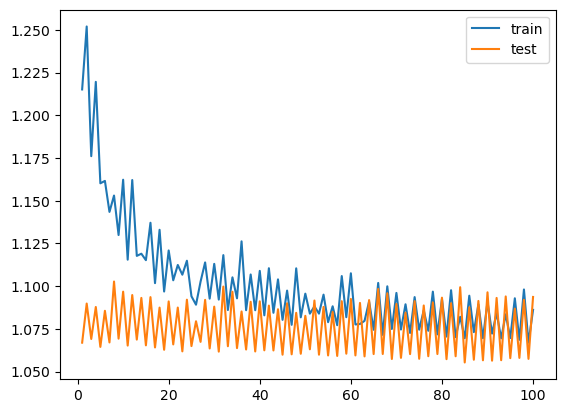

In [7]:
loss_array = np.array(loss_ls).reshape((2,epochs))

plt.plot(range(1,len(loss_array[0])+1),loss_array[0],label = "train")
plt.plot(range(1,len(loss_array[1])+1),loss_array[1],label= "test")
plt.legend()
plt.show()

In [8]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

net_test.to(device=torch.device("cpu"))

predict_probability = torch.max(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)[0]

predict_results = torch.argmax(F.softmax(net_test(test_set[:][0]),dim=-1),dim=-1)
real_results = test_set[:][1]

accuracy_score(real_results,predict_results)

0.4203703703703704

In [12]:
act_predict_bool = (predict_results != 1) & (predict_probability > 0.4)

act_predict_results = predict_results[act_predict_bool]
act_real_results = real_results[act_predict_bool]

accuracy_score(act_predict_results,act_real_results)


0.39375

In [13]:
act_predict_results.shape


torch.Size([160])

In [11]:
# saved_path = "./trained_model/Mac_LSTM.pth"

# torch.save(net_test.state_dict(),saved_path )